<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_05_auto_ml_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Tuning

In [0]:
COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v2'

In [2]:
if COLAB:
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects

Cloning into 'dl-projects'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1095 (delta 2), reused 0 (delta 0), pack-reused 1089
Receiving objects: 100% (1095/1095), 72.35 MiB | 27.75 MiB/s, done.
Resolving deltas: 100% (647/647), done.


In [0]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .
  !cp dl-projects/plot* .

In [0]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import matplotlib
import sys

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

import featuretools as ft

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, mean_squared_error, accuracy_score, average_precision_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

# from sklearn.ensemble import RandomForestClassifier

# from scikitplot.plotters import plot_precision_recall_curve

from dateutil.relativedelta import relativedelta

from IPython.display import display

from utils import *
from preprocess import *

import xgboost as xgb

np.set_printoptions(threshold=sys.maxsize)

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

from utils import feature_selection, plot_feature_importances
from plot import plot_correlation_matrix, plot_labelled_scatter

In [6]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [7]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.ft"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 4001M
-rw------- 1 root root 1548M Jan  7 00:07 feature_matrix_d2_v1.pkl
-rw------- 1 root root 2454M Jan 12 01:24 feature_matrix_d2_v2.ft
total 25M
-rw-r--r-- 1 root root  1M Jan 12 02:11 4D.zip
-rw-r--r-- 1 root root 25M Jan 12 02:11 labels.csv


In [0]:
data = pd.read_feather(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

In [13]:
data.shape, data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959893 entries, 0 to 959892
Columns: 335 entries, NumberId to year
dtypes: datetime64[ns](1), float64(214), int64(118), uint8(2)
memory usage: 2.4 GB


((959893, 335), None)

## Exploratory Data Analysis

### View data

In [0]:
feature_matrix = data.drop(columns=['NumberId', 'month', 'year'])

In [15]:
feature_matrix.columns

Index(['time', 'NUM_UNIQUE(Results.PrizeType)',
       'TIME_SINCE_FIRST(Results.DrawDate)', 'MIN(Results.TotalStrike)',
       'SKEW(Results.LuckyNo)', 'LAST(Results.results_index)',
       'SKEW(Results.TotalStrike)', 'AVG_TIME_BETWEEN(Results.DrawDate)',
       'LAST(Results.DrawNo)', 'MIN(Results.LuckyNo)',
       ...
       'SKEW(Results.CUM_MEAN(TotalStrike))',
       'MAX(Results.TIME_SINCE_PREVIOUS(DrawDate))',
       'CUM_MIN(TIME_SINCE(first_Results_time))',
       'SUM(Results.CUM_MEAN(TotalStrike))',
       'MAX(Results.CUM_SUM(TotalStrike))', 'CUM_MAX(SKEW(Results.DrawNo))',
       'TotalStrike', 'Label', 'LAST(Results.PrizeType)_Prize',
       'MODE(Results.PrizeType)_Prize'],
      dtype='object', length=332)

In [16]:
feature_matrix[feature_matrix['Label'] == 1 ].tail(4)

,time,NUM_UNIQUE(Results.PrizeType),TIME_SINCE_FIRST(Results.DrawDate),MIN(Results.TotalStrike),SKEW(Results.LuckyNo),LAST(Results.results_index),SKEW(Results.TotalStrike),AVG_TIME_BETWEEN(Results.DrawDate),LAST(Results.DrawNo),MIN(Results.LuckyNo),LAST(Results.TotalStrike),STD(Results.DrawNo),"TREND(Results.LuckyNo, DrawDate)",MAX(Results.TotalStrike),SUM(Results.DrawNo),MEAN(Results.DrawNo),MAX(Results.DrawNo),TIME_SINCE_LAST(Results.DrawDate),TIME_SINCE(first_Results_time),"TREND(Results.DrawNo, DrawDate)",MONTH(first_Results_time),MEAN(Results.LuckyNo),DAY(first_Results_time),MIN(Results.DrawNo),COUNT(Results),STD(Results.TotalStrike),MAX(Results.LuckyNo),MEAN(Results.TotalStrike),"TREND(Results.TotalStrike, DrawDate)",SUM(Results.TotalStrike),TIME_SINCE_PREVIOUS(first_Results_time),SUM(Results.LuckyNo),LAST(Results.LuckyNo),STD(Results.LuckyNo),SKEW(Results.DrawNo),PERCENTILE(STD(Results.DrawNo)),CUM_MAX(LAST(Results.DrawNo)),SKEW(Results.PERCENTILE(DrawNo)),CUM_SUM(SUM(Results.TotalStrike)),CUM_MAX(SUM(Results.TotalStrike)),...,CUM_SUM(NUM_UNIQUE(Results.PrizeType)),"TREND(Results.CUM_MEAN(TotalStrike), DrawDate)",SUM(Results.CUM_MIN(LuckyNo)),MAX(Results.PERCENTILE(TotalStrike)),"TREND(Results.TIME_SINCE(DrawDate), DrawDate)",SUM(Results.CUM_SUM(LuckyNo)),STD(Results.PERCENTILE(DrawNo)),MAX(Results.CUM_MIN(LuckyNo)),CUM_MEAN(MAX(Results.TotalStrike)),SUM(Results.CUM_MAX(LuckyNo)),SKEW(Results.CUM_SUM(LuckyNo)),SKEW(Results.TIME_SINCE(DrawDate)),LAST(Results.CUM_MEAN(TotalStrike)),CUM_MIN(TIME_SINCE_LAST(Results.DrawDate)),MIN(Results.CUM_MIN(LuckyNo)),CUM_SUM(MEAN(Results.LuckyNo)),MEAN(Results.PERCENTILE(DrawNo)),PERCENTILE(MIN(Results.TotalStrike)),MIN(Results.PERCENTILE(LuckyNo)),MIN(Results.PERCENTILE(DrawNo)),CUM_MIN(MEAN(Results.TotalStrike)),STD(Results.CUM_SUM(DrawNo)),CUM_MIN(MIN(Results.LuckyNo)),MAX(Results.CUM_MIN(TotalStrike)),"TREND(Results.PERCENTILE(DrawNo), DrawDate)",CUM_SUM(STD(Results.LuckyNo)),CUM_MEAN(SKEW(Results.TotalStrike)),NUM_UNIQUE(Results.DAY(DrawDate)),MAX(Results.CUM_MAX(LuckyNo)),MAX(Results.CUM_MIN(DrawNo)),SKEW(Results.CUM_MEAN(TotalStrike)),MAX(Results.TIME_SINCE_PREVIOUS(DrawDate)),CUM_MIN(TIME_SINCE(first_Results_time)),SUM(Results.CUM_MEAN(TotalStrike)),MAX(Results.CUM_SUM(TotalStrike)),CUM_MAX(SKEW(Results.DrawNo)),TotalStrike,Label,LAST(Results.PrizeType)_Prize,MODE(Results.PrizeType)_Prize
950205,2019-12-01,1,669254340.0,1,0.0,100862,0.0,78019200.0,479318,9957,1,127054.467100,0.0,1,2803674,311519.333333,479318,45100740.0,669254340.0,0.032599,9,9957,16,140498,9,0.0,9957,1,0.0,9,259200.0,89613,9957,0.0,-0.012912,0.3915,503819,-0.012910,98001,27,...,8990,0.0,0,0.500005,-60.0,2790393667,0.274341,0,1.0,89991,-0.012260,0.059923,1.0,86340.0,0,44993340,0.584676,0.50005,0.995897,0.215401,1,9.188577e+09,0,1,7.038956e-08,0.0,0.0,9,9999,40792,0.0,259200.0,669254340.0,9.0,100863,2.594704,1.0,1,1,1
950206,2019-12-01,1,750643140.0,1,0.0,69635,0.0,46483200.0,343510,9964,1,87070.473740,0.0,1,2426733,220612.090909,343510,285811140.0,750643140.0,0.031344,2,9964,17,100096,11,0.0,9964,1,0.0,11,0.0,109604,9964,0.0,-0.225108,0.0351,503819,-0.225105,82815,27,...,7475,0.0,0,0.500005,-60.0,2266456554,0.188005,0,1.0,109989,-0.222525,0.254912,1.0,86340.0,0,37372693,0.388385,0.50005,0.996554,0.128163,1,4.299607e+09,0,1,6.767882e-08,0.0,0.0,10,9999,40792,0.0,0.0,750643140.0,11.0,69636,2.594704,1.0,1,1,1
950207,2019-12-01,1,868233540.0,1,0.0,90599,0.0,93031200.0,434715,9989,1,111384.241449,0.0,1,1975525,219502.777778,434715,123983940.0,868233540.0,0.031669,5,9989,27,41692,9,0.0,9989,1,0.0,9,0.0,89901,9989,0.0,0.437460,0.1763,503819,0.437170,2590,21,...,218,0.0,19,0.500005,-60.0,1842751656,0.240496,19,1.0,89983,0.436740,-0.294986,1.0,86340.0,0,1114191,0.386014,0.50005,0.998836,0.002056,1,6.375740e+09,19,1,6.837804e-08,0.0,0.0,6,9999,40792,0.0,0.0,868233540.0,9.0,90600,1.882516,1.0,1,1,1
950208,2019-12-01,1,802828740.0,1,0.0,105310,0.0,79306560.0,498619,9990,1,158865.967466,0.0,1,2660545,241867.727273,498619,97

In [0]:
feature_matrix.sort_values(by=['time', 'MAX(Results.LuckyNo)'], inplace=True)

In [18]:
feature_matrix.tail(4)

,time,NUM_UNIQUE(Results.PrizeType),TIME_SINCE_FIRST(Results.DrawDate),MIN(Results.TotalStrike),SKEW(Results.LuckyNo),LAST(Results.results_index),SKEW(Results.TotalStrike),AVG_TIME_BETWEEN(Results.DrawDate),LAST(Results.DrawNo),MIN(Results.LuckyNo),LAST(Results.TotalStrike),STD(Results.DrawNo),"TREND(Results.LuckyNo, DrawDate)",MAX(Results.TotalStrike),SUM(Results.DrawNo),MEAN(Results.DrawNo),MAX(Results.DrawNo),TIME_SINCE_LAST(Results.DrawDate),TIME_SINCE(first_Results_time),"TREND(Results.DrawNo, DrawDate)",MONTH(first_Results_time),MEAN(Results.LuckyNo),DAY(first_Results_time),MIN(Results.DrawNo),COUNT(Results),STD(Results.TotalStrike),MAX(Results.LuckyNo),MEAN(Results.TotalStrike),"TREND(Results.TotalStrike, DrawDate)",SUM(Results.TotalStrike),TIME_SINCE_PREVIOUS(first_Results_time),SUM(Results.LuckyNo),LAST(Results.LuckyNo),STD(Results.LuckyNo),SKEW(Results.DrawNo),PERCENTILE(STD(Results.DrawNo)),CUM_MAX(LAST(Results.DrawNo)),SKEW(Results.PERCENTILE(DrawNo)),CUM_SUM(SUM(Results.TotalStrike)),CUM_MAX(SUM(Results.TotalStrike)),...,CUM_SUM(NUM_UNIQUE(Results.PrizeType)),"TREND(Results.CUM_MEAN(TotalStrike), DrawDate)",SUM(Results.CUM_MIN(LuckyNo)),MAX(Results.PERCENTILE(TotalStrike)),"TREND(Results.TIME_SINCE(DrawDate), DrawDate)",SUM(Results.CUM_SUM(LuckyNo)),STD(Results.PERCENTILE(DrawNo)),MAX(Results.CUM_MIN(LuckyNo)),CUM_MEAN(MAX(Results.TotalStrike)),SUM(Results.CUM_MAX(LuckyNo)),SKEW(Results.CUM_SUM(LuckyNo)),SKEW(Results.TIME_SINCE(DrawDate)),LAST(Results.CUM_MEAN(TotalStrike)),CUM_MIN(TIME_SINCE_LAST(Results.DrawDate)),MIN(Results.CUM_MIN(LuckyNo)),CUM_SUM(MEAN(Results.LuckyNo)),MEAN(Results.PERCENTILE(DrawNo)),PERCENTILE(MIN(Results.TotalStrike)),MIN(Results.PERCENTILE(LuckyNo)),MIN(Results.PERCENTILE(DrawNo)),CUM_MIN(MEAN(Results.TotalStrike)),STD(Results.CUM_SUM(DrawNo)),CUM_MIN(MIN(Results.LuckyNo)),MAX(Results.CUM_MIN(TotalStrike)),"TREND(Results.PERCENTILE(DrawNo), DrawDate)",CUM_SUM(STD(Results.LuckyNo)),CUM_MEAN(SKEW(Results.TotalStrike)),NUM_UNIQUE(Results.DAY(DrawDate)),MAX(Results.CUM_MAX(LuckyNo)),MAX(Results.CUM_MIN(DrawNo)),SKEW(Results.CUM_MEAN(TotalStrike)),MAX(Results.TIME_SINCE_PREVIOUS(DrawDate)),CUM_MIN(TIME_SINCE(first_Results_time)),SUM(Results.CUM_MEAN(TotalStrike)),MAX(Results.CUM_SUM(TotalStrike)),CUM_MAX(SKEW(Results.DrawNo)),TotalStrike,Label,LAST(Results.PrizeType)_Prize,MODE(Results.PrizeType)_Prize
954761,2019-12-01,1,814924740.0,1,0.0,102815,0.0,87187200.0,487818,9996,1,155434.539862,0.0,1,3265691,326569.100000,487818,30239940.0,814924740.0,0.032118,2,9996,3,68194,10,0.0,9996,1,0.0,10,0.0,99960,9996,0.0,-0.815323,0.8609,503819,-0.815320,53053,27,...,4686,0.0,1,0.500005,-60.0,3272730050,0.335619,1,1.0,99988,-0.817502,0.852532,1.0,86340.0,0,23457380,0.617172,0.50005,0.999573,0.059279,1,9.988761e+09,1,1,6.935050e-08,0.0,0.0,9,9999,40792,0.0,0.0,814924740.0,10.0,102816,2.433484,0.0,0,1,1
950811,2019-12-01,1,864518340.0,1,0.0,98916,0.0,67024800.0,470818,9997,1,138496.513075,0.0,1,3707589,285199.153846,470818,60220740.0,864518340.0,0.032002,7,9997,9,43592,13,0.0,9997,1,0.0,13,0.0,129961,9997,0.0,-0.280090,0.6019,503819,-0.280084,7401,24,...,623,0.0,20,0.500005,-60.0,3639155708,0.299046,19,1.0,129984,-0.280003,0.371697,1.0,86340.0,0,3139243,0.527844,0.50005,0.999681,0.006159,1,8.826249e+09,19,1,6.909885e-08,0.0,0.0,11,9999,40792,0.0,0.0,864518340.0,13.0,98917,2.084370,0.0,0,1,1
955548,2019-12-01,1,800409540.0,1,0.0,100856,0.0,94413600.0,479318,9998,1,170578.819963,0.0,1,2648563,294284.777778,479318,45100740.0,800409540.0,0.032145,7,9998,21,75394,9,0.0,9998,1,0.0,9,0.0,89982,9998,0.0,-0.227022,0.9640,503819,-0.227022,61894,27,...,5507,0.0,1,0.500005,-60.0,2612563817,0.368320,1,1.0,89990,-0.227689,0.258187,1.0,86340.0,0,27635914,0.547463,0.50005,0.999784,0.074827,1,1.106561e+10,1,1,6.940777e-08,0.0,0.0,7,9999,40792,0.0,0.0,800409540.0,9.0,100857,2.433484,0.0,0,1,1
956511,2019-12-01,1,778377540.0,1,0.0,86653,0.0,34656000.0,417515,9999,1,112266.950321,0.0,1,4694686,247088.736842,417515,154569540.0

In [19]:
origin_data[origin_data.LuckyNo == 9957]

,DrawNo,DrawDate,PrizeType,LuckyNo
22933,140498,1998-09-16,3rdPrizeNo,9957
25390,151099,1999-05-11,SpecialNo8,9957
44467,234104,2004-06-05,ConsolationNo5,9957
53282,272406,2006-09-02,SpecialNo10,9957
53956,275306,2006-11-08,SpecialNo8,9957
79659,387113,2013-04-24,ConsolationNo7,9957
81901,396813,2013-11-10,SpecialNo8,9957
98026,467017,2017-10-18,1stPrizeNo,9957
100862,479318,2018-06-27,ConsolationNo4,9957
106753,504919,2019-12-22,ConsolationNo7,9957


In [20]:
feature_matrix.describe().round(2)

,NUM_UNIQUE(Results.PrizeType),TIME_SINCE_FIRST(Results.DrawDate),MIN(Results.TotalStrike),SKEW(Results.LuckyNo),LAST(Results.results_index),SKEW(Results.TotalStrike),AVG_TIME_BETWEEN(Results.DrawDate),LAST(Results.DrawNo),MIN(Results.LuckyNo),LAST(Results.TotalStrike),STD(Results.DrawNo),"TREND(Results.LuckyNo, DrawDate)",MAX(Results.TotalStrike),SUM(Results.DrawNo),MEAN(Results.DrawNo),MAX(Results.DrawNo),TIME_SINCE_LAST(Results.DrawDate),TIME_SINCE(first_Results_time),"TREND(Results.DrawNo, DrawDate)",MONTH(first_Results_time),MEAN(Results.LuckyNo),DAY(first_Results_time),MIN(Results.DrawNo),COUNT(Results),STD(Results.TotalStrike),MAX(Results.LuckyNo),MEAN(Results.TotalStrike),"TREND(Results.TotalStrike, DrawDate)",SUM(Results.TotalStrike),TIME_SINCE_PREVIOUS(first_Results_time),SUM(Results.LuckyNo),LAST(Results.LuckyNo),STD(Results.LuckyNo),SKEW(Results.DrawNo),PERCENTILE(STD(Results.DrawNo)),CUM_MAX(LAST(Results.DrawNo)),SKEW(Results.PERCENTILE(DrawNo)),CUM_SUM(SUM(Results.TotalStrike)),CUM_MAX(SUM(Results.TotalStrike)),LAST(Results.CUM_MIN(TotalStrike)),...,CUM_SUM(NUM_UNIQUE(Results.PrizeType)),"TREND(Results.CUM_MEAN(TotalStrike), DrawDate)",SUM(Results.CUM_MIN(LuckyNo)),MAX(Results.PERCENTILE(TotalStrike)),"TREND(Results.TIME_SINCE(DrawDate), DrawDate)",SUM(Results.CUM_SUM(LuckyNo)),STD(Results.PERCENTILE(DrawNo)),MAX(Results.CUM_MIN(LuckyNo)),CUM_MEAN(MAX(Results.TotalStrike)),SUM(Results.CUM_MAX(LuckyNo)),SKEW(Results.CUM_SUM(LuckyNo)),SKEW(Results.TIME_SINCE(DrawDate)),LAST(Results.CUM_MEAN(TotalStrike)),CUM_MIN(TIME_SINCE_LAST(Results.DrawDate)),MIN(Results.CUM_MIN(LuckyNo)),CUM_SUM(MEAN(Results.LuckyNo)),MEAN(Results.PERCENTILE(DrawNo)),PERCENTILE(MIN(Results.TotalStrike)),MIN(Results.PERCENTILE(LuckyNo)),MIN(Results.PERCENTILE(DrawNo)),CUM_MIN(MEAN(Results.TotalStrike)),STD(Results.CUM_SUM(DrawNo)),CUM_MIN(MIN(Results.LuckyNo)),MAX(Results.CUM_MIN(TotalStrike)),"TREND(Results.PERCENTILE(DrawNo), DrawDate)",CUM_SUM(STD(Results.LuckyNo)),CUM_MEAN(SKEW(Results.TotalStrike)),NUM_UNIQUE(Results.DAY(DrawDate)),MAX(Results.CUM_MAX(LuckyNo)),MAX(Results.CUM_MIN(DrawNo)),SKEW(Results.CUM_MEAN(TotalStrike)),MAX(Results.TIME_SINCE_PREVIOUS(DrawDate)),CUM_MIN(TIME_SINCE(first_Results_time)),SUM(Results.CUM_MEAN(TotalStrike)),MAX(Results.CUM_SUM(TotalStrike)),CUM_MAX(SKEW(Results.DrawNo)),TotalStrike,Label,LAST(Results.PrizeType)_Prize,MODE(Results.PrizeType)_Prize
count,959893.0,9.598930e+05,959893.0,952257.0,959893.00,952257.0,9.589480e+05,959893.00,959893.00,959893.0,958948.00,952257.0,959893.0,959893.00,959893.00,959893.00,9.598930e+05,9.598930e+05,952257.00,959893.00,959893.00,959893.00,959893.00,959893.00,958948.0,959893.00,959893.0,952257.0,959893.00,959797.00,959893.00,959893.00,958948.0,952257.00,958948.00,959893.00,952257.00,959893.00,959893.00,959893.0,...,959893.00,952257.0,959893.00,959893.0,952257.0,9.598930e+05,958948.00,959893.00,959893.0,959893.00,952257.00,952257.00,959893.0,9.598930e+05,959893.00,959893.00,959893.00,959893.0,959893.00,959893.00,959893.0,9.589480e+05,959893.00,959893.0,952257.0,958948.0,952257.0,959893.00,959893.00,959893.0,952257.0,959893.00,9.598930e+05,959893.00,959893.00,952257.00,959893.00,959893.00,959893.0,959893.0
mean,1.0,6.586662e+08,1.0,0.0,80532.69,0.0,8.234844e+07,390906.91,4999.18,1.0,111342.20,0.0,1.0,2168380.75,237399.51,390906.91,7.736635e+07,6.586662e+08,0.03,6.67,4999.18,15.66,83952.25,9.05,0.0,4999.18,1.0,0.0,9.05,69770.51,45042.83,4999.18,0.0,-0.00,0.50,434121.08,-0.00,47640.32,23.19,1.0,...,4999.94,0.0,5.86,0.5,-60.0,2.061386e+09,0.28,4.73,1.0,90478.76,-0.00,0.06,1.0,1.811094e+05,0.00,25000458.18,0.50,0.5,0.50,0.11,1.0,6.239182e+09,4.73,1.0,0.0,0.0,0.0,7.83,9999.00,40792.0,0.0,64171.93,6.586662e+08,9.05,80533.69,2.35,0.03,0.03,1.0,1.0
std,0.0,1.119074e+08,0.0,0.0,13646.27,0.0,3.895532e+07,59335.80,2886.68,0.0,25772.65,0.0,0.0,904878.09,45425.90,59335.80,7.745884e+07,1.119074e+08,0.00,3.37,2886.68,8.81,42863.89,3.16,0.0,2886.68,0.0,0.0,3.16,619532.70,31606.21,2886.68,0.

In [21]:
print('Positive: ' + str(feature_matrix['Label'].value_counts()[0]) + ' which is ', round(feature_matrix['Label'].value_counts()[0]/len(feature_matrix) * 100,2), '% of the dataset')
print('Negative: ' + str(feature_matrix['Label'].value_counts()[1]) + ' which is ', round(feature_matrix['Label'].value_counts()[1]/len(feature_matrix) * 100,2), '% of the dataset')

Positive: 927839 which is  96.66 % of the dataset
Negative: 32054 which is  3.34 % of the dataset


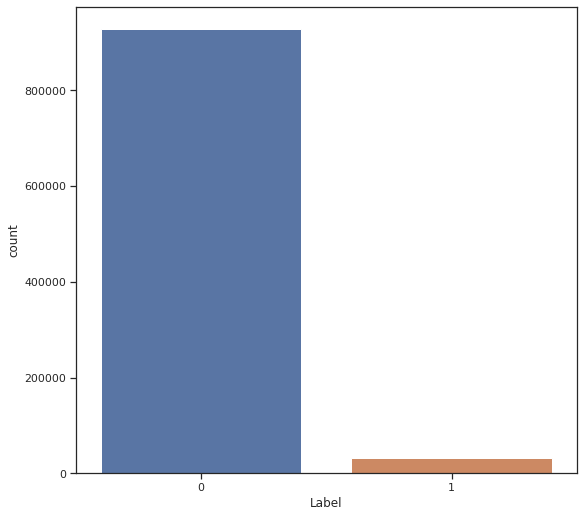

In [22]:
plt.figure(figsize=(8, 8))
sns.countplot('Label', data=feature_matrix)

In [23]:
feature_matrix.isna().sum().sort_values(ascending=False)

CUM_MEAN(TREND(Results.LuckyNo, DrawDate))      7636
SKEW(Results.CUM_MAX(LuckyNo))                  7636
SKEW(Results.PERCENTILE(DrawNo))                7636
SKEW(Results.TIME_SINCE_PREVIOUS(DrawDate))     7636
CUM_SUM(SKEW(Results.DrawNo))                   7636
                                                ... 
CUM_SUM(MIN(Results.DrawNo))                       0
SUM(Results.PERCENTILE(TotalStrike))               0
CUM_MEAN(TIME_SINCE_FIRST(Results.DrawDate))       0
CUM_SUM(MAX(Results.TotalStrike))                  0
time                                               0
Length: 332, dtype: int64

In [24]:
feature_matrix.isnull().sum().sort_values(ascending=False)

CUM_MEAN(TREND(Results.LuckyNo, DrawDate))      7636
SKEW(Results.CUM_MAX(LuckyNo))                  7636
SKEW(Results.PERCENTILE(DrawNo))                7636
SKEW(Results.TIME_SINCE_PREVIOUS(DrawDate))     7636
CUM_SUM(SKEW(Results.DrawNo))                   7636
                                                ... 
CUM_SUM(MIN(Results.DrawNo))                       0
SUM(Results.PERCENTILE(TotalStrike))               0
CUM_MEAN(TIME_SINCE_FIRST(Results.DrawDate))       0
CUM_SUM(MAX(Results.TotalStrike))                  0
time                                               0
Length: 332, dtype: int64

In [25]:
len(feature_matrix[feature_matrix.isnull().any(axis=1)].time.unique())

96

In [26]:
feature_matrix[feature_matrix.isnull().any(axis=1)].head()

,time,NUM_UNIQUE(Results.PrizeType),TIME_SINCE_FIRST(Results.DrawDate),MIN(Results.TotalStrike),SKEW(Results.LuckyNo),LAST(Results.results_index),SKEW(Results.TotalStrike),AVG_TIME_BETWEEN(Results.DrawDate),LAST(Results.DrawNo),MIN(Results.LuckyNo),LAST(Results.TotalStrike),STD(Results.DrawNo),"TREND(Results.LuckyNo, DrawDate)",MAX(Results.TotalStrike),SUM(Results.DrawNo),MEAN(Results.DrawNo),MAX(Results.DrawNo),TIME_SINCE_LAST(Results.DrawDate),TIME_SINCE(first_Results_time),"TREND(Results.DrawNo, DrawDate)",MONTH(first_Results_time),MEAN(Results.LuckyNo),DAY(first_Results_time),MIN(Results.DrawNo),COUNT(Results),STD(Results.TotalStrike),MAX(Results.LuckyNo),MEAN(Results.TotalStrike),"TREND(Results.TotalStrike, DrawDate)",SUM(Results.TotalStrike),TIME_SINCE_PREVIOUS(first_Results_time),SUM(Results.LuckyNo),LAST(Results.LuckyNo),STD(Results.LuckyNo),SKEW(Results.DrawNo),PERCENTILE(STD(Results.DrawNo)),CUM_MAX(LAST(Results.DrawNo)),SKEW(Results.PERCENTILE(DrawNo)),CUM_SUM(SUM(Results.TotalStrike)),CUM_MAX(SUM(Results.TotalStrike)),...,CUM_SUM(NUM_UNIQUE(Results.PrizeType)),"TREND(Results.CUM_MEAN(TotalStrike), DrawDate)",SUM(Results.CUM_MIN(LuckyNo)),MAX(Results.PERCENTILE(TotalStrike)),"TREND(Results.TIME_SINCE(DrawDate), DrawDate)",SUM(Results.CUM_SUM(LuckyNo)),STD(Results.PERCENTILE(DrawNo)),MAX(Results.CUM_MIN(LuckyNo)),CUM_MEAN(MAX(Results.TotalStrike)),SUM(Results.CUM_MAX(LuckyNo)),SKEW(Results.CUM_SUM(LuckyNo)),SKEW(Results.TIME_SINCE(DrawDate)),LAST(Results.CUM_MEAN(TotalStrike)),CUM_MIN(TIME_SINCE_LAST(Results.DrawDate)),MIN(Results.CUM_MIN(LuckyNo)),CUM_SUM(MEAN(Results.LuckyNo)),MEAN(Results.PERCENTILE(DrawNo)),PERCENTILE(MIN(Results.TotalStrike)),MIN(Results.PERCENTILE(LuckyNo)),MIN(Results.PERCENTILE(DrawNo)),CUM_MIN(MEAN(Results.TotalStrike)),STD(Results.CUM_SUM(DrawNo)),CUM_MIN(MIN(Results.LuckyNo)),MAX(Results.CUM_MIN(TotalStrike)),"TREND(Results.PERCENTILE(DrawNo), DrawDate)",CUM_SUM(STD(Results.LuckyNo)),CUM_MEAN(SKEW(Results.TotalStrike)),NUM_UNIQUE(Results.DAY(DrawDate)),MAX(Results.CUM_MAX(LuckyNo)),MAX(Results.CUM_MIN(DrawNo)),SKEW(Results.CUM_MEAN(TotalStrike)),MAX(Results.TIME_SINCE_PREVIOUS(DrawDate)),CUM_MIN(TIME_SINCE(first_Results_time)),SUM(Results.CUM_MEAN(TotalStrike)),MAX(Results.CUM_SUM(TotalStrike)),CUM_MAX(SKEW(Results.DrawNo)),TotalStrike,Label,LAST(Results.PrizeType)_Prize,MODE(Results.PrizeType)_Prize
363,2012-01-01,1,620265540.0,1,0.0,64949,0.0,4.214991e+07,323109,19,1,101777.042238,0.0,1,2500705,178621.785714,323109,72316740.0,620265540.0,0.03093,5,19,6,40792,14,0.0,19,1,0.0,14,NaN,266,19,0.0,0.070113,0.696425,323109,0.070115,14,14,...,1,0.0,40,0.500007,-60.0,2211177150,0.315275,19,1.0,129998,0.070944,-0.043829,1.0,72316740.0,0,19,0.427118,0.50005,0.001771,0.000162,1,4.322517e+09,19,1,9.581165e-08,0.0,0.0,11,9999,40792,0.0,86400.0,620265540.0,14.0,64950,0.070113,0.0,0,1,1
9017,2012-01-01,1,421027140.0,1,NaN,63742,NaN,3.393792e+08,317909,123,1,126014.206582,NaN,1,457607,228803.500000,317909,81647940.0,421027140.0,NaN,8,123,29,139698,2,0.0,123,1,NaN,2,259200.0,246,123,0.0,NaN,0.962392,363511,NaN,68968,21,...,8978,NaN,0,0.500007,NaN,431412305,0.390354,0,1.0,19998,NaN,NaN,1.0,86340.0,0,44911320,0.582566,0.50005,0.011334,0.306543,1,6.631006e+09,0,1,NaN,0.0,NaN,2,9999,40792,NaN,0.0,421027140.0,2.0,63743,NaN,0.0,0,1,1
8619,2012-01-01,1,452390340.0,1,NaN,64702,NaN,3.782592e+08,322109,135,1,139944.917278,NaN,1,446306,223153.000000,322109,74131140.0,452390340.0,NaN,8,135,31,124197,2,0.0,135,1,NaN,2,0.0,270,135,0.0,NaN,0.990259,363511,NaN,66239,21,...,8560,NaN,0,0.500007,NaN,418227262,0.433508,0,1.0,19998,NaN,NaN,1.0,86340.0,0,42705579,0.565062,0.50005,0.012533,0.258526,1,7.179265e+09,0,1,NaN,0.0,NaN,2,9999,40792,NaN,0.0,452390340.0,2.0,64703,NaN,0.0,0,1,1
9519,2012-01-01,1,361756740.0,1,NaN,49848,NaN,1.664064e+08,257505,185,1,61592.536175,NaN,1,427905,213952.500000,257505,195350340.0,361756740.0,NaN,7,185,15,170400,2,0.0,185,1,NaN,2,0.0,370,185,0.0,NaN,0.095903,363511,NaN,72040,21,...,9502,NaN,0,0.

### Data Cleansing

In [0]:
## Fill all NaN with 0
feature_matrix = feature_matrix.fillna(0)

In [34]:
feature_matrix.isnull().sum().sort_values(ascending=False)

MODE(Results.PrizeType)_Prize           0
STD(Results.CUM_MAX(TotalStrike))       0
MIN(Results.PERCENTILE(TotalStrike))    0
MIN(Results.CUM_MAX(DrawNo))            0
LAST(Results.CUM_MAX(DrawNo))           0
                                       ..
CUM_SUM(SKEW(Results.DrawNo))           0
MAX(Results.PERCENTILE(DrawNo))         0
LAST(Results.CUM_MIN(LuckyNo))          0
MIN(Results.CUM_MEAN(LuckyNo))          0
time                                    0
Length: 332, dtype: int64

In [35]:
feature_matrix.isna().sum().sort_values(ascending=False)

MODE(Results.PrizeType)_Prize           0
STD(Results.CUM_MAX(TotalStrike))       0
MIN(Results.PERCENTILE(TotalStrike))    0
MIN(Results.CUM_MAX(DrawNo))            0
LAST(Results.CUM_MAX(DrawNo))           0
                                       ..
CUM_SUM(SKEW(Results.DrawNo))           0
MAX(Results.PERCENTILE(DrawNo))         0
LAST(Results.CUM_MIN(LuckyNo))          0
MIN(Results.CUM_MEAN(LuckyNo))          0
time                                    0
Length: 332, dtype: int64

In [36]:
feature_matrix[feature_matrix.isnull().any(axis=1)].head()

,time,NUM_UNIQUE(Results.PrizeType),TIME_SINCE_FIRST(Results.DrawDate),MIN(Results.TotalStrike),SKEW(Results.LuckyNo),LAST(Results.results_index),SKEW(Results.TotalStrike),AVG_TIME_BETWEEN(Results.DrawDate),LAST(Results.DrawNo),MIN(Results.LuckyNo),LAST(Results.TotalStrike),STD(Results.DrawNo),"TREND(Results.LuckyNo, DrawDate)",MAX(Results.TotalStrike),SUM(Results.DrawNo),MEAN(Results.DrawNo),MAX(Results.DrawNo),TIME_SINCE_LAST(Results.DrawDate),TIME_SINCE(first_Results_time),"TREND(Results.DrawNo, DrawDate)",MONTH(first_Results_time),MEAN(Results.LuckyNo),DAY(first_Results_time),MIN(Results.DrawNo),COUNT(Results),STD(Results.TotalStrike),MAX(Results.LuckyNo),MEAN(Results.TotalStrike),"TREND(Results.TotalStrike, DrawDate)",SUM(Results.TotalStrike),TIME_SINCE_PREVIOUS(first_Results_time),SUM(Results.LuckyNo),LAST(Results.LuckyNo),STD(Results.LuckyNo),SKEW(Results.DrawNo),PERCENTILE(STD(Results.DrawNo)),CUM_MAX(LAST(Results.DrawNo)),SKEW(Results.PERCENTILE(DrawNo)),CUM_SUM(SUM(Results.TotalStrike)),CUM_MAX(SUM(Results.TotalStrike)),...,CUM_SUM(NUM_UNIQUE(Results.PrizeType)),"TREND(Results.CUM_MEAN(TotalStrike), DrawDate)",SUM(Results.CUM_MIN(LuckyNo)),MAX(Results.PERCENTILE(TotalStrike)),"TREND(Results.TIME_SINCE(DrawDate), DrawDate)",SUM(Results.CUM_SUM(LuckyNo)),STD(Results.PERCENTILE(DrawNo)),MAX(Results.CUM_MIN(LuckyNo)),CUM_MEAN(MAX(Results.TotalStrike)),SUM(Results.CUM_MAX(LuckyNo)),SKEW(Results.CUM_SUM(LuckyNo)),SKEW(Results.TIME_SINCE(DrawDate)),LAST(Results.CUM_MEAN(TotalStrike)),CUM_MIN(TIME_SINCE_LAST(Results.DrawDate)),MIN(Results.CUM_MIN(LuckyNo)),CUM_SUM(MEAN(Results.LuckyNo)),MEAN(Results.PERCENTILE(DrawNo)),PERCENTILE(MIN(Results.TotalStrike)),MIN(Results.PERCENTILE(LuckyNo)),MIN(Results.PERCENTILE(DrawNo)),CUM_MIN(MEAN(Results.TotalStrike)),STD(Results.CUM_SUM(DrawNo)),CUM_MIN(MIN(Results.LuckyNo)),MAX(Results.CUM_MIN(TotalStrike)),"TREND(Results.PERCENTILE(DrawNo), DrawDate)",CUM_SUM(STD(Results.LuckyNo)),CUM_MEAN(SKEW(Results.TotalStrike)),NUM_UNIQUE(Results.DAY(DrawDate)),MAX(Results.CUM_MAX(LuckyNo)),MAX(Results.CUM_MIN(DrawNo)),SKEW(Results.CUM_MEAN(TotalStrike)),MAX(Results.TIME_SINCE_PREVIOUS(DrawDate)),CUM_MIN(TIME_SINCE(first_Results_time)),SUM(Results.CUM_MEAN(TotalStrike)),MAX(Results.CUM_SUM(TotalStrike)),CUM_MAX(SKEW(Results.DrawNo)),TotalStrike,Label,LAST(Results.PrizeType)_Prize,MODE(Results.PrizeType)_Prize


### Feature Selection

In [0]:
# Feature scaling first??

In [38]:
print(feature_matrix.shape)
feature_matrix.columns

(959893, 332)


Index(['time', 'NUM_UNIQUE(Results.PrizeType)',
       'TIME_SINCE_FIRST(Results.DrawDate)', 'MIN(Results.TotalStrike)',
       'SKEW(Results.LuckyNo)', 'LAST(Results.results_index)',
       'SKEW(Results.TotalStrike)', 'AVG_TIME_BETWEEN(Results.DrawDate)',
       'LAST(Results.DrawNo)', 'MIN(Results.LuckyNo)',
       ...
       'SKEW(Results.CUM_MEAN(TotalStrike))',
       'MAX(Results.TIME_SINCE_PREVIOUS(DrawDate))',
       'CUM_MIN(TIME_SINCE(first_Results_time))',
       'SUM(Results.CUM_MEAN(TotalStrike))',
       'MAX(Results.CUM_SUM(TotalStrike))', 'CUM_MAX(SKEW(Results.DrawNo))',
       'TotalStrike', 'Label', 'LAST(Results.PrizeType)_Prize',
       'MODE(Results.PrizeType)_Prize'],
      dtype='object', length=332)

In [39]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label']))

Original shape:  (959893, 329)
0 missing columns with threshold: 90.
86 zero variance columns.
154 collinear columns removed with threshold: 0.95.
Total columns removed:  240
Shape after feature selection: (959893, 89).


In [40]:
feature_matrix_selection.shape, feature_matrix_selection.columns

((959893, 89),
 Index(['TIME_SINCE_FIRST(Results.DrawDate)', 'LAST(Results.results_index)',
        'AVG_TIME_BETWEEN(Results.DrawDate)', 'MIN(Results.LuckyNo)',
        'STD(Results.DrawNo)', 'SUM(Results.DrawNo)', 'MEAN(Results.DrawNo)',
        'TIME_SINCE_LAST(Results.DrawDate)', 'TREND(Results.DrawNo, DrawDate)',
        'MONTH(first_Results_time)', 'DAY(first_Results_time)',
        'MIN(Results.DrawNo)', 'COUNT(Results)',
        'TIME_SINCE_PREVIOUS(first_Results_time)', 'SUM(Results.LuckyNo)',
        'SKEW(Results.DrawNo)', 'PERCENTILE(STD(Results.DrawNo))',
        'CUM_MAX(LAST(Results.DrawNo))', 'CUM_SUM(SUM(Results.TotalStrike))',
        'CUM_MAX(SUM(Results.TotalStrike))', 'CUM_MAX(MAX(Results.LuckyNo))',
        'CUM_MIN(COUNT(Results))', 'PERCENTILE(COUNT(Results))',
        'CUM_MEAN(STD(Results.DrawNo))', 'CUM_MIN(STD(Results.DrawNo))',
        'CUM_MIN(MAX(Results.DrawNo))',
        'MEAN(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'CUM_MAX(SUM(Results.DrawNo)

In [0]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['TotalStrike'] = feature_matrix['TotalStrike']
feature_matrix_selection['Label'] = feature_matrix['Label']

### Feature Correlation

In [42]:
# Check without feature selection
# %time corrs = feature_matrix.corr().sort_values('Label')
# corrs['Label'].tail(100)

CUM_MEAN(MIN(Results.DrawNo))                0.001819
CUM_SUM(MIN(Results.DrawNo))                 0.001852
MIN(Results.PERCENTILE(DrawNo))              0.001972
TREND(Results.CUM_MAX(LuckyNo), DrawDate)    0.002065
MAX(Results.PERCENTILE(TotalStrike))         0.002320
                                               ...   
CUM_MEAN(SKEW(Results.TotalStrike))               NaN
MAX(Results.CUM_MIN(DrawNo))                      NaN
SKEW(Results.CUM_MEAN(TotalStrike))               NaN
LAST(Results.PrizeType)_Prize                     NaN
MODE(Results.PrizeType)_Prize                     NaN
Name: Label, Length: 100, dtype: float64

In [43]:
# Check with feature selection
%time corrs = feature_matrix_selection.corr().sort_values('Label')
corrs['Label'].tail(20)

TIME_SINCE_LAST(Results.DrawDate)                   0.000913
MIN(Results.TIME_SINCE_PREVIOUS(DrawDate))          0.000984
SKEW(Results.CUM_MAX(LuckyNo))                      0.000985
TIME_SINCE_PREVIOUS(first_Results_time)             0.000987
LAST(Results.CUM_MEAN(LuckyNo))                     0.000988
MAX(Results.CUM_MEAN(LuckyNo))                      0.001007
PERCENTILE(MEAN(Results.DrawNo))                    0.001022
CUM_SUM(SUM(Results.TotalStrike))                   0.001039
TREND(Results.PERCENTILE(LuckyNo), DrawDate)        0.001139
CUM_MAX(TIME_SINCE_PREVIOUS(first_Results_time))    0.001145
CUM_MIN(TIME_SINCE_LAST(Results.DrawDate))          0.001153
CUM_MIN(SKEW(Results.DrawNo))                       0.001267
TREND(Results.CUM_MEAN(LuckyNo), DrawDate)          0.001493
TREND(Results.PERCENTILE(DrawNo), DrawDate)         0.001528
PERCENTILE(MEAN(Results.TotalStrike))               0.001564
MIN(Results.DrawNo)                                 0.001718
STD(Results.CUM_MEAN(Luc

### Balancing data

In [0]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, AllKNN

balancer = AllKNN(random_state=42)

In [45]:
X = feature_matrix_selection.drop(columns = ['time', 'Label', 'TotalStrike'])
X.shape

(959893, 89)

In [46]:
y = feature_matrix_selection['Label']
y.shape, y.value_counts()[0], y.value_counts()[1]

((959893,), 927839, 32054)

In [0]:
# Normalized X first??

#X_bal, y_bal = balancer.fit_sample(X,y)
#X_bal.shape, y_bal.shape

In [0]:
#np.where(y_bal==0)[0].shape, np.where(y_bal==1)[0].shape, 

In [0]:
#len(np.where(y_bal==1)[0])/len(np.where(y_bal==0)[0]) * 100

## Modeling

In [0]:
def predict(dt, feature_matrix, return_probs = False): 
   
    feature_matrix['date'] = feature_matrix['time']

    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['date'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['date'] < dt, 'Label']

    print(f"Size of test labels {len(test_labels)}")
    print(f"Size of train labels {len(train_labels)}")
    
    # Features
    X_train = feature_matrix[feature_matrix['date'] < dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['date'] == dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    print(f"Size of X train {len(X_train)}")
    print(f"Size of X test  {len(X_test)}")
   
    feature_names = list(X_train.columns)
    
    # Impute and scale features
    pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'constant', fill_value=0)), 
                      ('scaler', StandardScaler())])

    # Fit and transform training data
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))
    
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    # https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
    # https://stats.stackexchange.com/questions/224512/reduce-false-positives-with-xgboost
    hit_ratio = float(train_labels.value_counts()[0]/train_labels.value_counts()[1]) 
    print(f"Hit ratio - {hit_ratio}")

    # Evaluation sets
    eval_set = [(X_train, y_train)]

    # Create the classifier
    model = xgb.XGBClassifier(n_jobs=-1, 
                             random_state = 42,
                             n_estimators=100, 
                             max_depth=3,
                             min_child_weight=1,
                             # criterion = 'entropy',
                             scale_pos_weight=hit_ratio,
                             #eval_metric=["error"], 
                             #eval_set=eval_set
                             )

    # Train 
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    # Total positive
    positive = np.where((predictions==1))
    print('Total predicted to be positive: ', len(positive[0]))
  
    # Calculate metrics
    rpt = classification_report(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    print('Classification report')
    print(rpt)
    print('Confusion matrix')
    print(cm)

    # Total predicted matches
    print('Predicted matches')
    # print(predictions)
    pred = np.where((predictions==1))
    print(len(pred[0]), pred)
    #print('Proba of predicted matches')
    #print(probs[pred[0]])

    if len(positive[0]) > 0:
      
      # Matching draws
      
      print('Matched draws')
      md = np.where((predictions==1) & (y_test==1))
      print(f"Count: {len(md[0])}, Index: {md}")
      month_data = feature_matrix.loc[feature_matrix['date'] == dt]
      numbers = month_data.iloc[md[0]][['MIN(Results.LuckyNo)']]

      #print(f"Predicted numbers :\n {numbers}")
      #print(probs[m[0]])
      #print('-----')
      #print(probs)
      
      display(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) & 
                          (origin_data['LuckyNo'].isin(numbers['MIN(Results.LuckyNo)']))].head(len(positive[0])))                                                   
    else:
      print('No luck this month')                 

    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    if return_probs:
        return fi, probs
    
    return fi


In [52]:
%time june_2019 = predict(pd.datetime(2019,6,1), feature_matrix_selection)

Size of test labels 10000
Size of train labels 889893
Size of X train 889893
Size of X test  10000
Training on 889893 observations.
Testing on 10000 observations.

Hit ratio - 28.829148929038315
Total predicted to be positive:  2740
Classification report
              precision    recall  f1-score   support

           0       0.97      0.73      0.83      9664
           1       0.03      0.28      0.06       336

    accuracy                           0.71     10000
   macro avg       0.50      0.50      0.44     10000
weighted avg       0.94      0.71      0.80     10000

Confusion matrix
[[7017 2647]
 [ 243   93]]
Predicted matches
2740 (array([   3,    6,   16,   17,   18,   21,   22,   28,   36,   37,   38,
         39,   42,   44,   50,   52,   54,   58,   62,   64,   67,   70,
         72,   75,   77,   80,   96,  104,  107,  111,  113,  117,  122,
        130,  131,  145,  146,  147,  148,  151,  152,  154,  155,  157,
        160,  163,  165,  171,  176,  178,  180,  182,  19

,DrawNo,DrawDate,PrizeType,LuckyNo
104562,495419,2019-06-01,ConsolationNo10,4336
104571,495419,2019-06-01,SpecialNo1,511
104576,495419,2019-06-01,SpecialNo5,1661
104586,495519,2019-06-02,ConsolationNo2,6124
104592,495519,2019-06-02,ConsolationNo8,2663
...,...,...,...,...
104894,496819,2019-06-30,SpecialNo10,2588
104895,496819,2019-06-30,SpecialNo2,3867
104898,496819,2019-06-30,SpecialNo5,4613
104899,496819,2019-06-30,SpecialNo6,5501


CPU times: user 7min 17s, sys: 151 ms, total: 7min 17s
Wall time: 1min 52s


In [0]:
# arr = np.array([  15,   19,   33,   36,   38,   42,   44,   52,   66,   72,   75,
#          77,   80,   82,   96,  107])
# feature_matrix[feature_matrix_selection['MAX(Results.LuckyNo)'].isin(arr[0:1])]

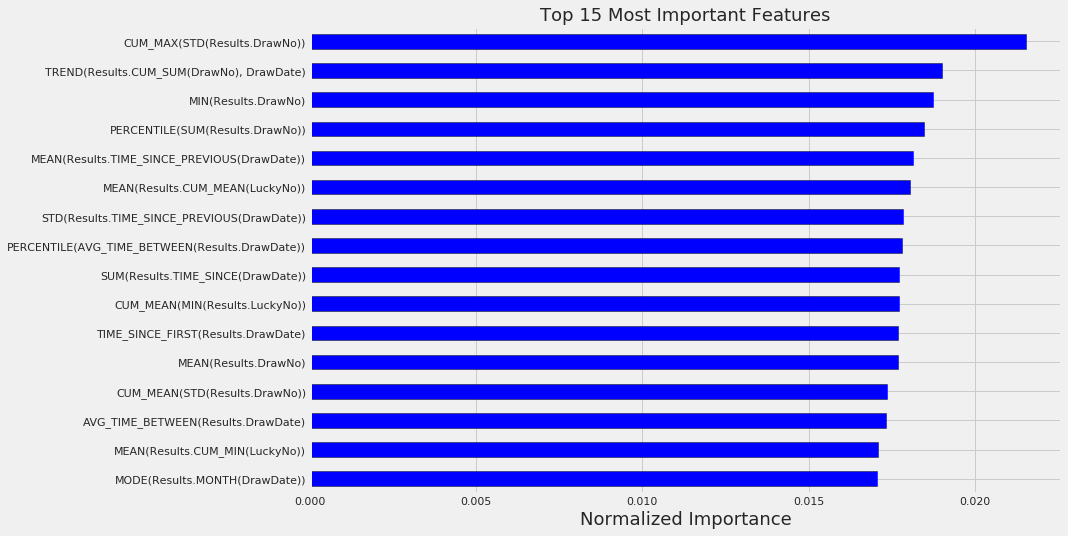

In [56]:
normalized_fi = plot_feature_importances(june_2019)

In [57]:
normalized_fi.head(70).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
feature,CUM_MAX(STD(Results.DrawNo)),"TREND(Results.CUM_SUM(DrawNo), DrawDate)",MIN(Results.DrawNo),PERCENTILE(SUM(Results.DrawNo)),MEAN(Results.TIME_SINCE_PREVIOUS(DrawDate)),MEAN(Results.CUM_MEAN(LuckyNo)),STD(Results.TIME_SINCE_PREVIOUS(DrawDate)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),SUM(Results.TIME_SINCE(DrawDate)),CUM_MEAN(MIN(Results.LuckyNo)),TIME_SINCE_FIRST(Results.DrawDate),MEAN(Results.DrawNo),CUM_MEAN(STD(Results.DrawNo)),AVG_TIME_BETWEEN(Results.DrawDate),MEAN(Results.CUM_MIN(LuckyNo)),MODE(Results.MONTH(DrawDate)),SKEW(Results.CUM_MAX(LuckyNo)),CUM_MAX(SUM(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),CUM_MIN(COUNT(Results)),MEAN(Results.TIME_SINCE(DrawDate)),SKEW(Results.TIME_SINCE_PREVIOUS(DrawDate)),CUM_MEAN(AVG_TIME_BETWEEN(Results.DrawDate)),CUM_SUM(SUM(Results.TotalStrike)),PERCENTILE(MEAN(Results.DrawNo)),"TREND(Results.CUM_MIN(LuckyNo), DrawDate)",SUM(Results.LuckyNo),PERCENTILE(SKEW(Results.DrawNo)),CUM_MEAN(SKEW(Results.DrawNo)),"TREND(Results.TIME_SINCE_PREVIOUS(DrawDate), D...",CUM_MAX(SUM(Results.DrawNo)),STD(Results.DrawNo),DAY(first_Results_time),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",LAST(Results.CUM_MEAN(LuckyNo)),LAST(Results.DAY(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(DrawNo)),TIME_SINCE_PREVIOUS(first_Results_time),"TREND(Results.CUM_MEAN(LuckyNo), DrawDate)",CUM_MAX(TIME_SINCE_LAST(Results.DrawDate)),LAST(Results.results_index),CUM_MEAN(TIME_SINCE_LAST(Results.DrawDate)),MAX(Results.CUM_MEAN(LuckyNo)),PERCENTILE(LAST(Results.DrawNo)),TIME_SINCE_LAST(Results.DrawDate),SKEW(Results.CUM_MEAN(LuckyNo)),MODE(Results.DAY(DrawDate)),STD(Results.CUM_MEAN(LuckyNo)),SKEW(Results.CUM_SUM(DrawNo)),"TREND(Results.PERCENTILE(LuckyNo), DrawDate)","TREND(Results.DrawNo, DrawDate)",CUM_MIN(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(COUNT(Results)),MIN(Results.LuckyNo),CUM_SUM(SKEW(Results.DrawNo)),SKEW(Results.DrawNo),SUM(Results.CUM_MIN(LuckyNo)),"TREND(Results.PERCENTILE(DrawNo), DrawDate)",CUM_MIN(SUM(Results.DrawNo)),CUM_MAX(MEAN(Results.DrawNo)),SUM(Results.DrawNo),"TREND(Results.PERCENTILE(TotalStrike), DrawDate)",CUM_MAX(SKEW(Results.DrawNo)),CUM_MIN(TIME_SINCE_LAST(Results.DrawDate)),NUM_UNIQUE(Results.DAY(DrawDate)),MONTH(first_Results_time),LAST(Results.MONTH(DrawDate)),CUM_MIN(STD(Results.DrawNo)),CUM_MAX(LAST(Results.DrawNo))
importance,0.0215247,0.0189995,0.0187512,0.0184554,0.0181314,0.0180355,0.0178327,0.0177965,0.0177314,0.0177048,0.0176932,0.0176794,0.0173691,0.0173205,0.0170959,0.0170463,0.0166889,0.0166669,0.0165732,0.0164827,0.0163383,0.0162656,0.0161296,0.0161285,0.0159254,0.0158653,0.0158554,0.0156967,0.0156119,0.0153008,0.0151799,0.014808,0.0147241,0.0146093,0.0142832,0.0141365,0.0140507,0.0139465,0.0139145,0.0137711,0.0133876,0.0133404,0.0132272,0.0132062,0.0128842,0.0128491,0.0126795,0.0126547,0.0123436,0.0122923,0.0121527,0.0121434,0.0118885,0.0118395,0.0117437,0.011722,0.0116039,0.0115972,0.0114021,0.0113195,0.0111605,0.0111547,0.0102863,0.0102088,0.00944539,0.00885275,0.00871386,0.00820641,0.0075196,0.00729891
importance_normalized,0.0215247,0.0189995,0.0187512,0.0184554,0.0181314,0.0180355,0.0178327,0.0177965,0.0177314,0.0177048,0.0176932,0.0176794,0.0173691,0.0173205,0.0170959,0.0170463,0.0166889,0.0166669,0.0165732,0.0164827,0.0163383,0.0162656,0.0161296,0.0161285,0.0159254,0.0158653,0.0158554,0.0156967,0.015612,0.0153008,0.0151799,0.014808,0.0147241,0.0146093,0.0142832,0.0141365,0.0140507,0.0139465,0.0139145,0.0137711,0.0133876,0.0133404,0.0132272,0.0132062,0.0128842,0.0128491,0.0126795,0.0126547,0.0123436,0.0122923,0.0121527,0.0121434,0.0118885,0.0118395,0.0117437,0.011722,0.0116039,0.0115972,0.0114021,0.0113195,0.0111605,0.0111547,0.0102863,0.0102088,0.00944539,0.00885275,0.00871386,0.00820641,0.0075196,0.00729891
cumulative_i

In [0]:
#origin_data[ (origin_data['DrawDate'].dt.year==2019) & (origin_data['DrawDate'].dt.month==6)].DrawDate.unique()

In [0]:
#feature_matrix[ (feature_matrix['time'].dt.year==2019) & (feature_matrix['time'].dt.month==6)]

In [0]:
# Loop through from June to Dec
start_mt = pd.datetime(2019,6,1)
how_many_mt = 7
for i in range(how_many_mt):
  month_to_predict = start_mt + relativedelta(months=i)
  print(f"\n{month_to_predict}\n-------------------\n")
  %time predict(month_to_predict, feature_matrix_selection)


2019-06-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 889893
Size of X train 889893
Size of X test  10000
Training on 889893 observations.
Testing on 10000 observations.

Hit ratio - 28.829148929038315
Total predicted to be positive:  1211
Precision: 0.03386
Recall: 0.12202
F1 Score: 0.05301
ROC AUC: 0.51624
Accuracy: 0.8535
Average precision: 0.03363
Confusion matrix
[[8494 1170]
 [ 295   41]]
Predicted matches
1211 (array([  15,   19,   33,   36,   38,   42,   44,   52,   66,   72,   75,
         77,   80,   82,   96,  107,  111,  117,  121,  131,  148,  151,
        152,  157,  160,  193,  201,  210,  217,  219,  226,  229,  230,
        239,  244,  271,  272,  279,  282,  283,  288,  298,  322,  323,
        328,  362,  377,  380,  393,  397,  418,  422,  429,  436,  468,
        479,  480,  482,  487,  496,  502,  507,  511,  520,  526,  536,
        537,  544,  550,  553,  558,  567,  572,  580,  581,  588,  592,
        595,  604,  623,  634,  

,DrawNo,DrawDate,PrizeType,LuckyNo
104673,495919,2019-06-12,1stPrizeNo,15
104789,496419,2019-06-22,2ndPrizeNo,44


CPU times: user 6min 19s, sys: 382 ms, total: 6min 19s
Wall time: 1min 40s

2019-07-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 899893
Size of X train 899893
Size of X test  10000
Training on 899893 observations.
Testing on 10000 observations.

Hit ratio - 28.828400013258644
Total predicted to be positive:  1897
Precision: 0.02952
Recall: 0.17834
F1 Score: 0.05066
ROC AUC: 0.47975
Accuracy: 0.7901
Average precision: 0.03106
Confusion matrix
[[7845 1841]
 [ 258   56]]
Predicted matches
1897 (array([   1,    2,    3,   28,   33,   38,   42,   52,   66,   72,   75,
         77,   80,   96,  102,  104,  105,  107,  111,  117,  118,  121,
        127,  129,  130,  142,  145,  146,  148,  151,  152,  154,  157,
        168,  171,  173,  176,  178,  182,  185,  186,  191,  193,  197,
        201,  205,  210,  216,  219,  226,  228,  230,  235,  236,  239,
        241,  244,  248,  249,  250,  253,  254,  259,  260,  262,  271,
        272,  274,  276,  279,

,DrawNo,DrawDate,PrizeType,LuckyNo
104996,497319,2019-07-13,2ndPrizeNo,28
105186,498119,2019-07-30,ConsolationNo4,66


CPU times: user 8min 2s, sys: 382 ms, total: 8min 2s
Wall time: 2min 7s

2019-08-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 909893
Size of X train 909893
Size of X test  10000
Training on 909893 observations.
Testing on 10000 observations.

Hit ratio - 28.849194633074173
Total predicted to be positive:  1575
Precision: 0.02476
Recall: 0.1242
F1 Score: 0.04129
ROC AUC: 0.47404
Accuracy: 0.8189
Average precision: 0.03058
Confusion matrix
[[8150 1536]
 [ 275   39]]
Predicted matches
1575 (array([  18,   28,   36,   38,   42,   49,   52,   62,   67,   72,   77,
         88,   96,  113,  115,  117,  118,  121,  142,  146,  151,  157,
        163,  173,  176,  178,  180,  185,  188,  191,  197,  198,  203,
        205,  206,  216,  219,  226,  229,  239,  240,  241,  243,  253,
        254,  259,  261,  262,  266,  271,  272,  273,  279,  291,  294,
        295,  315,  317,  322,  323,  326,  328,  336,  338,  340,  342,
        344,  352,  356,  364,  36

,DrawNo,DrawDate,PrizeType,LuckyNo


CPU times: user 8min 4s, sys: 373 ms, total: 8min 5s
Wall time: 2min 7s

2019-09-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 919893
Size of X train 919893
Size of X test  10000
Training on 919893 observations.
Testing on 10000 observations.

Hit ratio - 28.869565217391305
Total predicted to be positive:  1667
Precision: 0.03659
Recall: 0.19304
F1 Score: 0.06152
ROC AUC: 0.51543
Accuracy: 0.8139
Average precision: 0.03256
Confusion matrix
[[8078 1606]
 [ 255   61]]
Predicted matches
1667 (array([   2,    5,   18,   20,   28,   33,   36,   38,   42,   49,   50,
         52,   65,   72,   75,   77,   80,   81,   88,   96,  102,  104,
        107,  110,  111,  114,  115,  118,  121,  127,  129,  131,  132,
        137,  146,  148,  151,  152,  164,  171,  173,  177,  183,  184,
        185,  188,  191,  197,  201,  203,  205,  206,  210,  216,  219,
        220,  225,  226,  229,  230,  236,  239,  241,  244,  249,  250,
        253,  259,  262,  263,  2

,DrawNo,DrawDate,PrizeType,LuckyNo
105617,500019,2019-09-08,2ndPrizeNo,28


CPU times: user 6min 18s, sys: 208 ms, total: 6min 18s
Wall time: 1min 40s

2019-10-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 929893
Size of X train 929893
Size of X test  10000
Training on 929893 observations.
Testing on 10000 observations.

Hit ratio - 28.88760325265966
Total predicted to be positive:  1972
Precision: 0.03296
Recall: 0.20505
F1 Score: 0.05679
ROC AUC: 0.49251
Accuracy: 0.7841
Average precision: 0.03196
Confusion matrix
[[7776 1907]
 [ 252   65]]
Predicted matches
1972 (array([  12,   17,   18,   20,   25,   31,   33,   38,   41,   42,   49,
         50,   52,   54,   62,   63,   65,   67,   69,   72,   79,   80,
         87,   91,   96,   97,   98,  102,  106,  110,  111,  112,  114,
        115,  124,  125,  131,  137,  156,  160,  173,  176,  177,  187,
        188,  193,  195,  197,  201,  205,  207,  216,  218,  219,  220,
        223,  225,  226,  229,  237,  245,  246,  258,  262,  263,  265,
        272,  279,  280,  298, 

,DrawNo,DrawDate,PrizeType,LuckyNo
106181,502419,2019-10-30,SpecialNo1,31
106182,502419,2019-10-30,SpecialNo10,38


CPU times: user 6min 21s, sys: 199 ms, total: 6min 21s
Wall time: 1min 41s

2019-11-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 939893
Size of X train 939893
Size of X test  10000
Training on 939893 observations.
Testing on 10000 observations.

Hit ratio - 28.904327076041998
Total predicted to be positive:  1566
Precision: 0.0281
Recall: 0.14286
F1 Score: 0.04696
ROC AUC: 0.49059
Accuracy: 0.8214
Average precision: 0.03041
Confusion matrix
[[8170 1522]
 [ 264   44]]
Predicted matches
1566 (array([   0,    2,   18,   28,   33,   42,   49,   50,   51,   52,   54,
         67,   72,   80,   92,   96,   97,  102,  106,  107,  111,  113,
        115,  117,  125,  127,  131,  132,  137,  138,  156,  157,  173,
        177,  193,  197,  199,  201,  202,  203,  205,  206,  210,  219,
        220,  225,  226,  227,  229,  230,  237,  240,  243,  244,  246,
        250,  258,  259,  260,  272,  276,  278,  279,  280,  281,  283,
        288,  290,  291,  295, 

,DrawNo,DrawDate,PrizeType,LuckyNo
106297,502919,2019-11-09,SpecialNo10,51


CPU times: user 6min 22s, sys: 186 ms, total: 6min 22s
Wall time: 1min 41s

2019-12-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 949893
Size of X train 949893
Size of X test  10000
Training on 949893 observations.
Testing on 10000 observations.

Hit ratio - 28.929201588001764
Total predicted to be positive:  1403
Precision: 0.02994
Recall: 0.13291
F1 Score: 0.04887
ROC AUC: 0.48493
Accuracy: 0.8365
Average precision: 0.03138
Confusion matrix
[[8323 1361]
 [ 274   42]]
Predicted matches
1403 (array([   2,   18,   19,   33,   42,   50,   52,   54,   65,   67,   72,
         96,  102,  106,  107,  111,  113,  115,  117,  118,  121,  131,
        151,  157,  165,  177,  194,  195,  197,  201,  202,  203,  205,
        206,  210,  216,  219,  220,  226,  229,  230,  239,  240,  241,
        243,  258,  259,  261,  271,  272,  279,  281,  283,  291,  313,
        314,  322,  326,  328,  342,  352,  353,  357,  363,  380,  382,
        384,  385,  392,  397,

,DrawNo,DrawDate,PrizeType,LuckyNo


CPU times: user 6min 36s, sys: 179 ms, total: 6min 36s
Wall time: 1min 45s


In [0]:
# origin_data[ (origin_data['DrawDate'].dt.year==2019) & (origin_data['DrawDate'].dt.month==12)].DrawDate.unique()